In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import gc
import warnings
import os
import time

from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

#warnings.simplefilter(action='ignore', category=FutureWarning)

print(os.listdir("Projet+Mise+en+prod+-+home-credit-default-risk"))

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))



['application_test.csv', '.DS_Store', 'HomeCredit_columns_description.csv', 'POS_CASH_balance.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'application_train.csv', 'bureau.csv', 'previous_application.csv', 'bureau_balance.csv', 'sample_submission.csv']


In [2]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [3]:
# Training data
#app_train = pd.read_csv('../Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv')
app_train = pd.read_csv('Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Training data shape:  (307511, 122)
Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [4]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    #check which cols are categorical 
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    #get dummy variables for categorical variables
    df = pd.get_dummies(df, columns = categorical_columns, dummy_na = nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('Projet+Mise+en+prod+-+home-credit-default-risk/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    
    # put the two datasets together
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        # Encode the object as an enumerated type or categorical variable.
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df



In [5]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('Projet+Mise+en+prod+-+home-credit-default-risk/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('Projet+Mise+en+prod+-+home-credit-default-risk/bureau_balance.csv', nrows = num_rows)

    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    # bb is the df and bb_cat are the new cols
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    # in the new cols of the bureau balance
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
        #print(bb_aggregations)
        
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [6]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('Projet+Mise+en+prod+-+home-credit-default-risk/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg



In [7]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('Projet+Mise+en+prod+-+home-credit-default-risk/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [8]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('Projet+Mise+en+prod+-+home-credit-default-risk/installments_payments.csv', 
                      nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [9]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('Projet+Mise+en+prod+-+home-credit-default-risk/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [10]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [11]:
def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    return df


In [12]:
if __name__ == "__main__":
    with timer("Full model run"):
        df = main()
        df

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 16s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 16s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 10s
Installments payments df shape: (339587, 26)
Process installments payments - done in 20s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 11s
Full model run - done in 77s


In [13]:
df.shape

(356251, 798)

# Trying for Hyperparameter Search

In [14]:
from sklearn.metrics import confusion_matrix

def my_comp_score(y_true, y_pred):
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    tn_weight = 1
    fp_weight = 0
    fn_weight = -10
    tp_weight = 0

    # gain function for company, true positives and false positives don't matter that much to us
    # we want to penalise the false negatives, and we want to say yes to true negatives
    gain = tp*(tp_weight) + tn*(tn_weight) + fp*(fp_weight) + fn*(fn_weight)
    
    # best represents scenario where there are no false negatives or false postives
    # so all false positives would be correctly shown as negative
    # and all false negatives would be correctly show as positive
    best = (tn + fp) * tn_weight + (tp + fn) * tp_weight
    
    # baseline is a naive model that predicts non default(negative) for everyone
    # but all true positives and false negatives would be incorrectly shown as negative
    baseline = (tn + fp) * tn_weight + (tp + fn) * fn_weight
    
    score = (gain - baseline) / (best - baseline)
    
    return score

In [15]:
from sklearn.metrics import fbeta_score, make_scorer
make_scorer(my_comp_score)

make_scorer(my_comp_score)

In [16]:
import re

# Divide in training/validation and test data
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]


# Cross validation model
#if stratified:
#    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
#else:
#    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    
# Create arrays and dataframes to store results
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

# Sklearn stuff
#from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# Load and split dataset
#x, y = load_breast_cancer(return_X_y=True)

x_train, x_test, y_train, y_test = train_test_split(train_df[feats], train_df['TARGET'], 
                                                    test_size=0.3, random_state = 22)



### from hyperopt

In [19]:
from hyperopt import fmin, tpe, hp, anneal, Trials

# HyperOpt: Optimizer
from hyperopt import tpe

kf = KFold(n_splits = 5)

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def gb_mse_cv(params, random_state = 22, cv = kf, X = x_train, y= y_train):
    # the function gets a set of variable parameters in "param"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
              'learning_rate': params['learning_rate'],
              'num_leaves': int(params['num_leaves']),
              'min_data_in_leaf': int(params['min_data_in_leaf'])
              }
    
    # we use this params to create a new LGBM Regressor
    model = LGBMClassifier(random_state = random_state, **params)
    
    # and then conduct the cross validation with the same folds as before
    score = -cross_val_score(model, X, y, cv=cv, scoring= make_scorer(my_comp_score), 
                             n_jobs=-1).mean()

    return score


In [ ]:
%%time

n_iter = 50

# possible values of parameters
space={'n_estimators': hp.quniform('n_estimators', 100, 5000, 1),
       'max_depth' : hp.quniform('max_depth', 2, 20, 1),
       'num_leaves' : hp.quniform('num_leaves', 2, 40, 1),
       'learning_rate': hp.loguniform('learning_rate', -5, 0),
       'min_data_in_leaf': hp.quniform('min_data_in_leaf', 2, 40, 1)
      }

# trials will contain logging information
trials = Trials()

best=fmin(fn=gb_mse_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.RandomState(58) # fixing random state for the reproducibility
         )

# computing the score on the test set
model = LGBMClassifier(random_state= 54, n_estimators=int(best['n_estimators']),
                       max_depth=int(best['max_depth']),learning_rate=best['learning_rate'],
                       num_leaves = int(best['num_leaves']), 
                       min_data_in_leaf = int(best['min_data_in_leaf'])
                      )

model.fit(x_train, y_train)

print("Best  {:.3f} params {}".format( gb_mse_cv(best), best))


In [ ]:
print("Best  {:.3f} params {}".format( gb_mse_cv(best), best))

In [ ]:
#tpe_test_score=mean_squared_error(x_test, model.predict(y_test))

tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['learning_rate'][0],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
tpe_results_df.plot(subplots=True,figsize=(10, 10))

In [ ]:
import pickle
import joblib

def save_pkl_joblib(model_path):
    joblib.dump(model, model_path+"model.sav")
    #joblib.dump(vectorizer_model, model_path+"vectorizer.sav")
    print ("====done saving into pickle using Joblib!====")

def save_pkl_pickle(model_path):
    pickle.dump(model, open(model_path+"model.pickle", 'wb'))
    #pickle.dump(vectorizer_model, open(model_path+"vectorizer.pickle", "wb"))
    print ("====done saving into pickle using Pickle!====")

Project_path = "gitfirstproj"
model_path = Project_path 
#+ "/classification/models/"
#model, vectorizer_model = train_test_model(data["text"], data["category"])
save_pkl_pickle(model_path)
save_pkl_joblib(model_path)

In [ ]:
def loading_pickle(model_path):
    #vectorizer = pickle.load(open(model_path+"vectorizer.pickle",'rb'))
    model = pickle.load(open(model_path+"model.pickle",'rb'))
    return model
    #return vectorizer, model


def loading_joblibPickle(model_path):
    #vectorizer = joblib.load(model_path+"vectorizer.sav")
    model = joblib.load(model_path+"model.sav")
    return model 
    #return vectorizer, model

### # HyperOpt-Sklearn 

In [29]:
import hyperopt

hyperopt.tpe.suggest

<function hyperopt.tpe.suggest(new_ids, domain, trials, seed, prior_weight=1.0, n_startup_jobs=20, n_EI_candidates=24, gamma=0.25, verbose=True)>

In [34]:
# HyperOpt-Sklearn 
from hpsklearn import HyperoptEstimator, gradient_boosting, ada_boost
from hpsklearn import any_classifier
from hpsklearn import any_preprocessing


# Initialize Estimator
# classifier: The search is done for the complete suite of classifiers
# preprocessing: The preprocessing is donde for the complete suite of preprocessors
# algo: Optimizer algorithm (Tree-structure of Parzen Trees)
# max_evals: Number of iterations

# gradient_boosting

model = HyperoptEstimator(classifier = gradient_boosting('my_grad_boost'),
                          preprocessing=any_preprocessing('pre'), 
                          algo = hyperopt.tpe.suggest, 
                          max_evals=10, 
                          trial_timeout=30)

# Training
model.fit(x_train, y_train)

# Results
print(f"Train score: {model.score(x_train, y_train)}")
print(f"Test score: {model.score(x_test, y_test)}")

# Best model
print(f"Optimal configuration: {model.best_model()}")

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

job exception: Input contains infinity or a value too large for dtype('float64').



  0%|          | 0/1 [00:06<?, ?trial/s, best loss=?]


ValueError: Input contains infinity or a value too large for dtype('float64').

## Launching the model

In [25]:
import re

num_folds= 10
stratified= False
#debug= debug

# Divide in training/validation and test data
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
del df
gc.collect()

# Cross validation model
if stratified:
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
else:
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    
# Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]


Starting LightGBM. Train shape: (307507, 798), test shape: (48744, 798)


In [26]:
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
    train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
    valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
    
    train_x.to_csv("MY_train_x.csv")
    valid_x.to_csv("MY_valid_x.csv")
    valid_y.to_csv("MY_valid_y.csv")

    # LightGBM parameters found by Bayesian optimization
    clf = LGBMClassifier(
        nthread=4,
        n_estimators=10000,
        learning_rate=0.02,
        num_leaves=34,
        colsample_bytree=0.9497036,
        subsample=0.8715623,
        max_depth=8,
        reg_alpha=0.041545473,
        reg_lambda=0.0735294,
        min_split_gain=0.0222415,
        min_child_weight=39.3259775,
        silent=-1,
        verbose=-1, )

    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

    oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    
    valid_preds = clf.predict(valid_x, num_iteration=clf.best_iteration_)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis = 0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    #del clf, train_x, train_y, valid_x, valid_y
    #gc.collect()

print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
valid_preds

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.796937	training's binary_logloss: 0.234847	valid_1's auc: 0.775923	valid_1's binary_logloss: 0.24683
[400]	training's auc: 0.819329	training's binary_logloss: 0.225295	valid_1's auc: 0.786496	valid_1's binary_logloss: 0.24275
[600]	training's auc: 0.834077	training's binary_logloss: 0.219246	valid_1's auc: 0.790546	valid_1's binary_logloss: 0.241363
[800]	training's auc: 0.846244	training's binary_logloss: 0.214265	valid_1's auc: 0.79268	valid_1's binary_logloss: 0.240699
[1000]	training's auc: 0.856872	training's binary_logloss: 0.209823	valid_1's auc: 0.793482	valid_1's binary_logloss: 0.240434
[1200]	training's auc: 0.86648	training's binary_logloss: 0.205634	valid_1's auc: 0.79366	valid_1's binary_logloss: 0.240392
[1400]	training's auc: 0.875651	training's binary_logloss: 0.20155

array([0., 0., 0., ..., 0., 0., 0.])

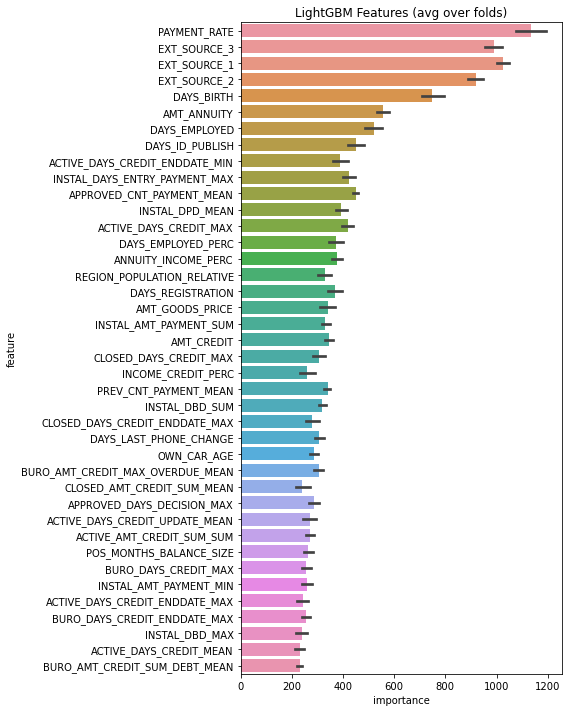

In [48]:
display_importances(feature_importance_df)

In [28]:
valid_y.shape

(30750,)

In [27]:
valid_preds.shape

(30750,)

In [34]:
from sklearn.metrics import confusion_matrix

conf_lgm = confusion_matrix(valid_y, valid_preds)
conf_lgm

array([[28190,   107],
       [ 2293,   160]])

In [42]:
pd.crosstab(valid_y, valid_preds)

col_0,0.0,1.0
TARGET,,
0.0,28190,107
1.0,2293,160


In [30]:
tn, fp, fn, tp = confusion_matrix(valid_y, valid_preds).ravel()

In [31]:
tn

28190

In [32]:
fp

107

In [39]:
fn

2293

In [40]:
tp

160

In [46]:
from sklearn.metrics import confusion_matrix


def my_comp_score(y_true, y_pred):
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    tn_weight = 1
    fp_weight = 0
    fn_weight = -10
    tp_weight = 0

    # gain function for company, true positives and false positives don't matter that much to us
    # we want to penalise the false negatives, and we want to say yes to true negatives
    gain = tp*(tp_weight) + tn*(tn_weight) + fp*(fp_weight) + fn*(fn_weight)
    
    # best represents scenario where there are no false negatives or false postives
    # so all false positives would be cforrectly shown as negative
    # and all false negatives would be correctly show as positive
    best = (tn + fp) * tn_weight + (tp + fn) * tp_weight
    
    # baseline is a navie model that predicts non default(negative) for everyone
    # but all true positives and false negatives would be incorrectly shown as negative
    baseline = (tn + fp) * tn_weight + (tp + fn) * fn_weight
    
    score = (gain - baseline) / (best - baseline)
    
    return score

In [47]:
from sklearn.metrics import fbeta_score, make_scorer
make_scorer(my_comp_score)

make_scorer(my_comp_score)

# Function Version

In [ ]:
    with timer("Run LightGBM with kfold"):
            submission_file_name = "submission_kernel02.csv"
        feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)

In [ ]:


def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
  
  
    
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df